<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Прогнозирование заказов такси
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  
Для выполнения задачи требуется:

Загрузить данные и выполнить их ресемплирование по одному часу.  
- Проанализировать данные.  
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.  
- Проверить данные на тестовой выборке и сделать выводы.  

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

При загрузке датасета используем столбец с датой и временем в качестве индекса.

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Ресемплируем данные по одному часу.

In [6]:
df = df.resample('1H').sum()

Для обучения модели нам потребуются признаки.  
Добавим столбцы отдельно по дням недели и месяца, а также по часу.

In [7]:
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

Вычислим скользящее среднее.

In [8]:
df['rolling_mean'] = df['num_orders'].shift().rolling(15).mean()

И создадим несколько отстающих значений.

In [9]:
for lag in range(1, 5):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [10]:
df.head()

,num_orders,day,day_of_week,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,NaN,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,NaN,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,NaN,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,1,3,4,NaN,66.0,71.0,85.0,124.0


От пропусков избавимся уже после анализа данных.

## Анализ

Рассмотрим общую динамику количества заказов.

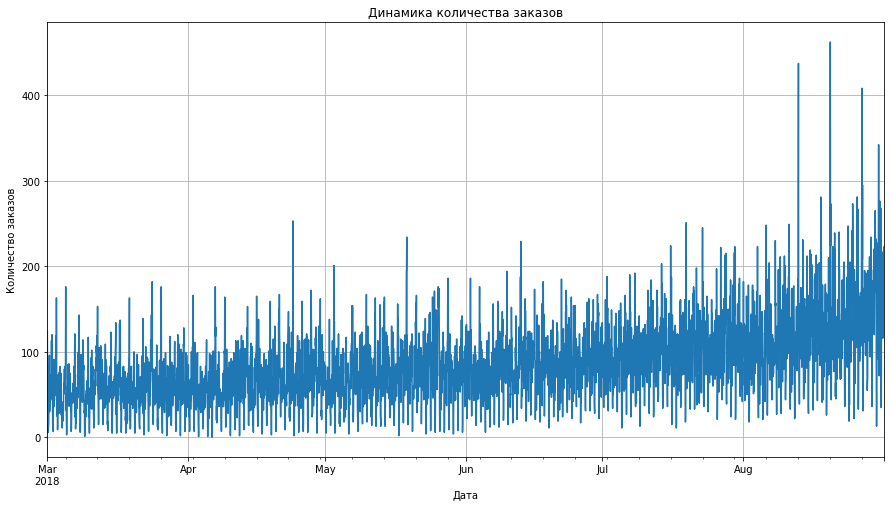

In [11]:
df['num_orders'].plot(figsize=(15, 8), grid=True, title='Динамика количества заказов', xlabel='Дата', ylabel='Количество заказов');

Уже подсчитанные данные скользящего среднего добавят графику наглядности.

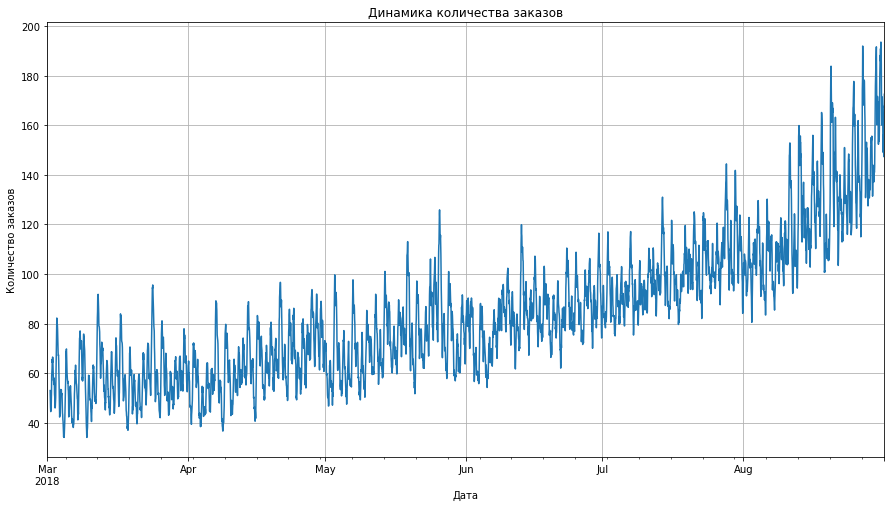

In [12]:
df['rolling_mean'].plot(figsize=(15, 8), grid=True, title='Динамика количества заказов', xlabel='Дата', ylabel='Количество заказов');

Август - главная пора отпусков, чем он ближе, тем больше заказов такси в аэропортах, вполне логично.  
Теперь взглянем на распределение внутри месяца.

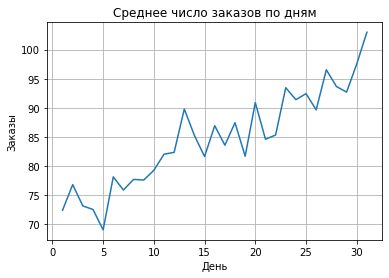

In [13]:
df.pivot_table(index='day', values='num_orders', aggfunc='mean').plot(title='Среднее число заказов по дням', xlabel='День', ylabel='Заказы', grid=True, legend=False);

Любопытно,что ближе к концу месяца заказов заметно больше чем в начальных числах.  
Рассмотрим данные по дням недели.

<AxesSubplot:title={'center':'Распределение заказов по дням недели'}, xlabel='День недели', ylabel='Заказы'>

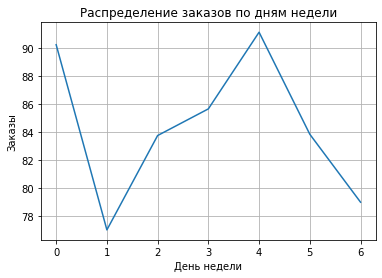

In [14]:
df.pivot_table(index='day_of_week', values='num_orders', aggfunc='mean').plot(title='Распределение заказов по дням недели', xlabel='День недели', ylabel='Заказы', grid=True, legend=False)

Понедельник и Пятница ожидаемо лидируют, лично для меня, небольшим сюрпризом оказалось достаточно низкое количество заказов по Воскресеньям.  
Осталось изучить данные по часам.

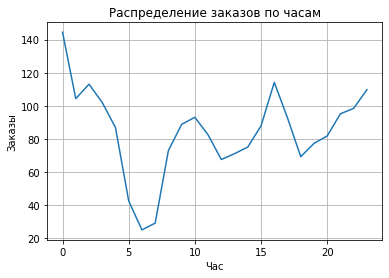

In [15]:
df.pivot_table(index='hour', values='num_orders', aggfunc='mean').plot(title='Распределение заказов по часам', xlabel='Час', ylabel='Заказы', grid=True, legend=False);

Пиковые показатели в районе полуночи могут быть обусловлены увеличенными интервалами или полным прекращение работы общественного транспорта. Меньше всего заказов приходит ранним утром(6-7 часов утра).  

Также изучим тренды и сезонность, для этого проведем декомпозицию данных.

In [16]:
decomposed = seasonal_decompose(df['num_orders'])

Text(0, 0.5, 'Заказы')

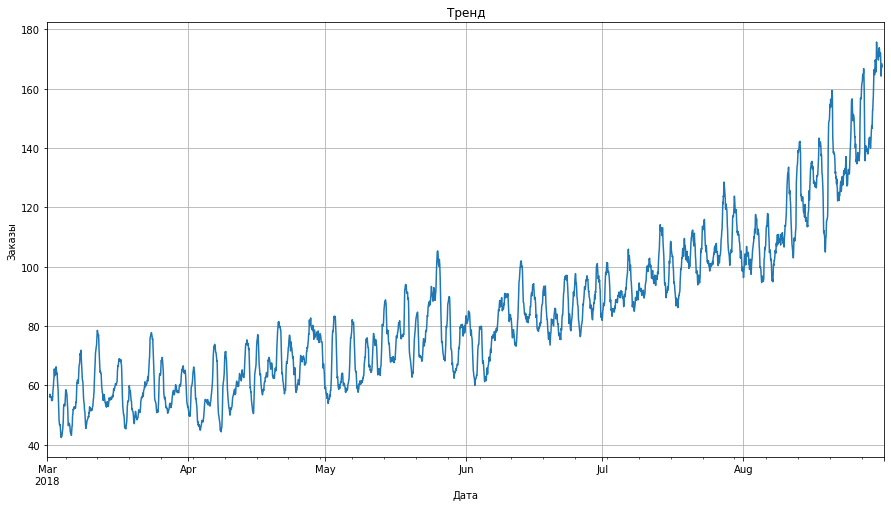

In [17]:
plt.figure(figsize=(15, 8))
decomposed.trend.plot(grid=True)
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Заказы')

Тренд связан с приближением периода отпусков, никаких сюрпризов.

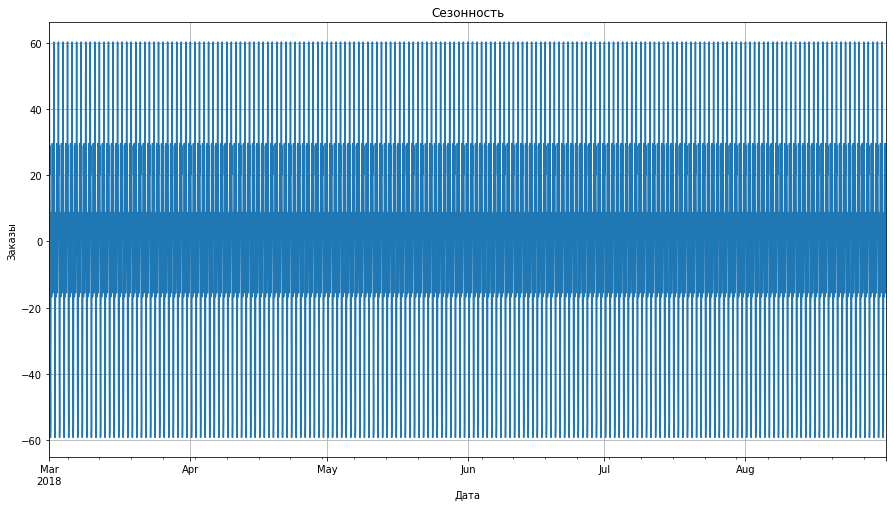

In [18]:
plt.figure(figsize=(15, 8))
decomposed.seasonal.plot(grid=True)
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Заказы');

Сезонность же наблюдается только рамках суток.

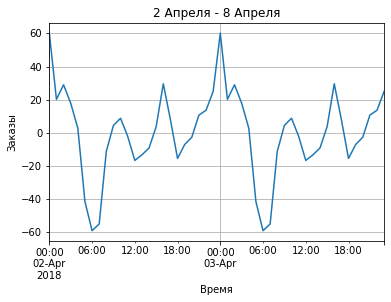

In [19]:
decomposed.seasonal['2018-04-02': '2018-04-03'].plot(grid=True)
plt.title('2 Апреля - 8 Апреля')
plt.xlabel('Время')
plt.ylabel('Заказы');

Если приглядеться, легко приметить уже знакомый рисунок суточного распределения заказов.  
Данные выглядят вполне адекватными, их определенно можно брать за основу для обучения моделей.

## Обучение

Избавимся от строк с пропущенными значениями.

In [20]:
df = df.dropna()

Целевой признак - значения столбца 'num_orders'.

In [21]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

Кросс-валидация для временных рядов не подойдет, поэтому в дополнение к обучающей и тестовой выборке нам понадобится валидационная.

In [22]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.1, shuffle=False)

In [23]:
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_valid.shape)
display(target_valid.shape)

(3564, 8)

(3564,)

(396, 8)

(396,)

(396, 8)

(396,)

Начнем с простого дерева решений.

In [24]:
best_model = None
best_result = 10000
best_depth = 0
for leaves in range(9, 99, 10):
    for depth in range(1, 7):
        model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaves, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = mean_squared_error(predictions, target_valid, squared=False)
        if result < best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_leaves = leaves
display('best result', best_result)
display('best depth', best_depth)
display('best leaves', best_leaves)

'best result'

36.34247295454583

'best depth'

6

'best leaves'

19

Теперь посмотрим как справится модель случайного леса.

In [25]:
best_model = None
best_result = 10000
best_depth = 0
best_leaves = 0
for leaves in range(9, 49, 10):
    for depth in range(1, 7):
        model = RandomForestRegressor(max_depth=depth, min_samples_leaf=leaves, n_estimators=150, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = mean_squared_error(predictions, target_valid, squared=False)
        if result < best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_leaves = leaves
display('best result', best_result)
display('best depth', best_depth)
display('best leaves', best_leaves)

'best result'

35.665621545370044

'best depth'

6

'best leaves'

9

Результат улучшился, но совсем незначительно.  
Теперь попрубуем линейную модель, все они показали схожие результаты, лучший был у линейной регресии.

In [26]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
mean_squared_error(predictions, target_valid, squared=False)

42.05974716137421

Результат заметно слабее чем у других моделей.  
И наконец проверим градиентный бустинг.

In [27]:
model = CatBoostRegressor(loss_function='RMSE', max_depth=5, grow_policy='Lossguide', max_leaves=10, iterations=70, random_state=12345)
model.fit(features_train, target_train, verbose=10)
predictions = model.predict(features_valid)
mean_squared_error(predictions, target_valid, squared=False)

Learning rate set to 0.434832
0:	learn: 30.4911406	total: 143ms	remaining: 9.88s
10:	learn: 22.0151098	total: 161ms	remaining: 864ms
20:	learn: 20.7636592	total: 179ms	remaining: 417ms
30:	learn: 19.7502549	total: 198ms	remaining: 249ms
40:	learn: 18.9989129	total: 215ms	remaining: 152ms
50:	learn: 18.2259126	total: 232ms	remaining: 86.5ms
60:	learn: 17.7080938	total: 250ms	remaining: 36.9ms
69:	learn: 17.3799708	total: 266ms	remaining: 0us


32.47833251236362

Лучший результат, эту модель и берем на тестирование.

## Тестирование

Объединим обучающую и валидационную выборки.

In [28]:
display(features_train.shape)
display(target_train.shape)

(3564, 8)

(3564,)

In [29]:
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)

In [30]:
display(features_train.shape)
display(target_train.shape)

(3960, 8)

(3960,)

In [31]:
model = CatBoostRegressor(loss_function='RMSE', max_depth=5, grow_policy='Lossguide', max_leaves=10, iterations=70, random_state=12345)
model.fit(features_train, target_train, verbose=10)
predictions = model.predict(features_test)
mean_squared_error(predictions, target_test, squared=False)

Learning rate set to 0.442131
0:	learn: 31.9124240	total: 2.16ms	remaining: 149ms
10:	learn: 23.0916120	total: 20.8ms	remaining: 112ms
20:	learn: 21.3697866	total: 38.9ms	remaining: 90.8ms
30:	learn: 20.4014791	total: 57.6ms	remaining: 72.4ms
40:	learn: 19.6444906	total: 75.9ms	remaining: 53.7ms
50:	learn: 19.0450289	total: 94.5ms	remaining: 35.2ms
60:	learn: 18.5570697	total: 112ms	remaining: 16.6ms
69:	learn: 18.0913134	total: 129ms	remaining: 0us


44.207216064530336

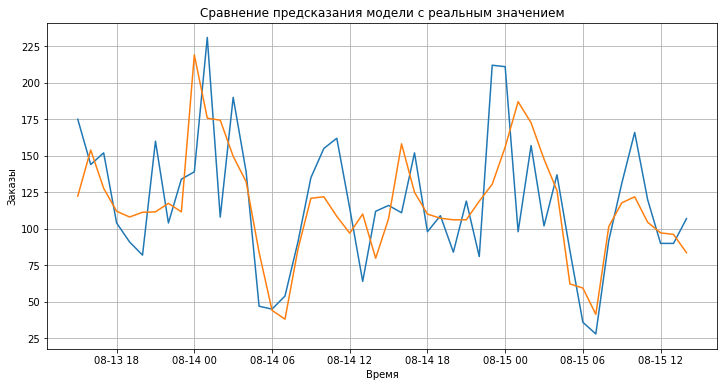

In [100]:
plt.figure(figsize=(12, 6))
plt.grid(visible=True)
plt.plot(target_test[0: 48])
plt.plot(pd.Series(data=predictions, index=target_test.index)[0: 48])
plt.title('Сравнение предсказания модели с реальным значением')
plt.xlabel('Время')
plt.ylabel('Заказы');

На графике можно заметить, что при общей схожести рисунка, предсказания часто спешат или запаздывают буквально на один час, это вполне может быть результатом малого объема данных для обучения.

Значение RMSE меньше 48, осталось сравнить его с результатом констатной модели и прогнозированием предыдущим значением ряда.

In [32]:
dummy_predictions = np.ones(target_test.shape) * np.full(target_test.shape, target_train.median())
mean_squared_error(dummy_predictions, target_test, squared=False)

87.24205906985632

In [33]:
dummy_predictions = target_test.shift()
dummy_predictions.iloc[0] = target_train.iloc[-1]
mean_squared_error(dummy_predictions, target_test, squared=False)

58.91761802963282

Результат модели превосходит оба варианта проверки. Задача выполнена!

## Вывод
Предоставленные данные позволяют выполнить поставленную задачу.  
Было проведено ресемплирование данных по часу.  
Выделены признаки для обучения моделей.  
В результате анализа, подтверждена адекватность данных.  
Из четырех обученных моделей выбрана лучшая.  
Выбранная модель протестирована и прошла проверку качества против константной модели и предсказания предыдущим значением ряда.